## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
import re
import gc
import copy

from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import nltk.data

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm
from transformers import DistilBertTokenizer, BertTokenizer
import transformers

from radam import RAdam
from text_data import TextDataset5, AugTextDataset3
from bert import CustomBert3
from multilabel_cross_fold import MultilabelStratifiedKFold
from learning import Learner
from lr_finder import LRFinder
from one_cycle import OneCycleLR
from text_cleaning import clean_data
from create_features import get_categorical_features
from losses_metrics import spearmanr_torch, spearmanr_np, optimize_rounding_params, get_cvs, spearmanr
from inference import infer
from eda import eda
from common import *
from utils.helpers import init_logger, init_seed

%matplotlib inline
pd.set_option('max_colwidth',400)

## Loading and preparing data

In [2]:
pd.set_option('max_rows', 500)
pd.set_option('max_columns', 500)
path = 'data/'
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
test = pd.read_csv(f'{path}test.csv').fillna(' ')
train = pd.read_csv(f'{path}train.csv').fillna(' ')
train_aug_ru = pd.read_csv(f'{path}train_aug_ru.csv', index_col=0)

In [3]:
train['question_title_ru'] = train_aug_ru.values
train[['question_title', 'question_title_ru']][:100]

,question_title,question_title_ru
0,What am I losing when using extension tubes instead of a macro lens?,What do I lose when I use extensions instead of a macro lens?
1,What is the distinction between a city and a sprawl/metroplex... between downtown and a commercial district?,What is the difference between a city and a metropolis... between a center and a commercial district?
2,Maximum protusion length for through-hole component pins,Length of tube for through pins
3,Can an affidavit be used in Beit Din?,Can an affidavit be used in Bindin?
4,How do you make a binary image in Photoshop?,How do you create a binary lifestyle?
5,Column Grouping with Title in DataTables,Column with the heading in the tablets
6,core file size with ulimit,the size of the main file with ulimit
7,How do you get your Steam games to run on Ubuntu through Wine or something similar?,How do you make your Steam games run on Ubuntu through Wine or something like that?
8,High memory usage Windows Server 2008r2 on VMware,High Memory Windows 2008r2 on VMware
9,How do you grapple in Dead Rising 3?,How do you graph in Dead Rising 3?


In [4]:
train_aug = train.copy()
train_aug['question_title_ru'] = train_aug_ru.values

In [5]:
%%time
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# sentence_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
seg_ids_train, ids_train = {}, {}
seg_ids_test, ids_test = {}, {}
seg_ids_aug, ids_aug = {}, {}
max_seq_len = 512
for mode, df in [('train', train), ('test', test), ('aug', train_aug)]:
    for text, cols in [('question', ['question_title', 'question_body']), 
                       ('answer', ['question_title', 'answer'])]:
        ids, seg_ids, sent_ids = [], [], []
        for x1, x2 in tqdm(df[cols].values):
            encoded_inputs = tokenizer.encode_plus(
                x1, x2, add_special_tokens=True, max_length=max_seq_len, pad_to_max_length=True, 
                return_token_type_ids=True
            )
            ids.append(encoded_inputs['input_ids'])
            seg_ids.append(encoded_inputs['token_type_ids'])
        if mode == 'train': 
            ids_train[text] = np.array(ids)
            seg_ids_train[text] = np.array(seg_ids)
        elif mode == 'aug': 
            ids_aug[text] = np.array(ids)
            seg_ids_aug[text] = np.array(seg_ids)
        else: 
            ids_test[text] = np.array(ids)
            seg_ids_test[text] = np.array(seg_ids)


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()



CPU times: user 1min 2s, sys: 422 ms, total: 1min 2s
Wall time: 1min 2s


In [6]:
train_host, test_host, host_dict, host_dict_reverse = get_categorical_features(train, test, 'host')
train_category, test_category, category_dict, category_dict_reverse = \
    get_categorical_features(train, test, 'category')

In [7]:
cat_features_train = train_category.reshape(-1, 1)
cat_features_test = test_category.reshape(-1, 1)
ohe = OneHotEncoder()
ohe.fit(cat_features_train)
cat_features_train = ohe.transform(cat_features_train).toarray()
cat_features_test = ohe.transform(cat_features_test).toarray()

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [8]:
for col in TARGETS:
    train[col] = train[col].rank(method="average")
train[TARGETS] = MinMaxScaler().fit_transform(train[TARGETS])
y = train[TARGETS].values.astype(np.float32)
ix = np.where(train.groupby("question_body")["host"].transform("count") == 1)[0]

In [9]:
num_workers = 10
bs = 2
TextDataset = AugTextDataset3

In [10]:
bs_test = 2
test_loader = DataLoader(
    TextDataset5(cat_features_test, ids_test['question'], ids_test['answer'], 
                seg_ids_test['question'], seg_ids_test['answer'], test.index),
    batch_size=bs_test, shuffle=False, num_workers=num_workers, drop_last=False
)

## Training model

In [11]:
lr = 0.001
loss_fn = nn.BCEWithLogitsLoss()
device = 'cuda'
n_epochs = 4
grad_accum = 4
weight_decay = 0.01
model_name = 'siamese_bert_4'
checkpoint_dir = 'checkpoints/'
early_stopping = None
n_folds = 10

In [12]:
def get_optimizer_param_groups(model, lr, weight_decay):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 
         'weight_decay': weight_decay, 'lr': lr},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 
         'weight_decay': 0.0, 'lr': lr}
    ]
    return optimizer_grouped_parameters


def get_optimizer(model, lr, weight_decay):
    return transformers.AdamW(
        get_optimizer_param_groups(model.head, lr, weight_decay)
        + get_optimizer_param_groups(model.bert, lr / 100, weight_decay)
    )

Fold 1 started at Sat Jan 25 14:09:33 2020


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


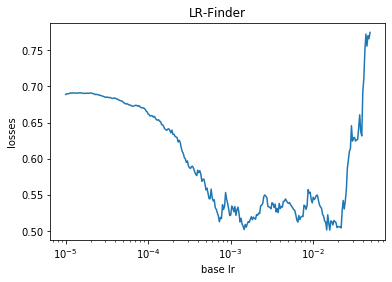

epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50898 - spearmanr 0.24703
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47097 - spearmanr 0.38575


/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


best model: epoch 0 - 0.38575
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45616 - spearmanr 0.39788
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45279 - spearmanr 0.41519
best model: epoch 1 - 0.41519
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43288 - spearmanr 0.4588
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44961 - spearmanr 0.41814
best model: epoch 2 - 0.41814
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41139 - spearmanr 0.51237
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45471 - spearmanr 0.41728
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.41814
Starting inference for model: checkpoints/siamese_bert_4_fold_1_best.pth



Averaged Val. score: 0.4181407440949466
Starting inference for model: checkpoints/siamese_bert_4_fold_1_best.pth



Fold 2 started at Sat Jan 25 14:50:30 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.51006 - spearmanr 0.24222
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46894 - spearmanr 0.38366
best model: epoch 0 - 0.38366
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45661 - spearmanr 0.39432
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45913 - spearmanr 0.41754
best model: epoch 1 - 0.41754
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43245 - spearmanr 0.45872
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45271 - spearmanr 0.4254
best model: epoch 2 - 0.4254
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41043 - spearmanr 0.51385
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45684 - spearmanr 0.42225
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42540
Starting inference for model: checkpoints/siamese_bert_4_fold_2_best.pth



Averaged Val. score: 0.4253973336588596
Starting inference for model: checkpoints/siamese_bert_4_fold_2_best.pth



Fold 3 started at Sat Jan 25 15:30:17 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50916 - spearmanr 0.24448
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47134 - spearmanr 0.37311
best model: epoch 0 - 0.37311
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45587 - spearmanr 0.39776
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46256 - spearmanr 0.39571
best model: epoch 1 - 0.39571
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43119 - spearmanr 0.46218
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.46089 - spearmanr 0.3938
model not improved for 1 epochs
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.4096 - spearmanr 0.51575
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46233 - spearmanr 0.3964
best model: epoch 3 - 0.3964
TRAINING END: Best score achieved on epoch 3 - 0.39640
Starting inference for model: checkpoints/siamese_bert_4_fold_3_best.pth



Averaged Val. score: 0.39640340824113973
Starting inference for model: checkpoints/siamese_bert_4_fold_3_best.pth



Fold 4 started at Sat Jan 25 16:09:33 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50953 - spearmanr 0.24598
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47399 - spearmanr 0.36497
best model: epoch 0 - 0.36497
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45619 - spearmanr 0.39717
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45676 - spearmanr 0.39165
best model: epoch 1 - 0.39165
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43305 - spearmanr 0.45759
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45295 - spearmanr 0.40239
best model: epoch 2 - 0.40239
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41173 - spearmanr 0.51159
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45694 - spearmanr 0.40021
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.40239
Starting inference for model: checkpoints/siamese_bert_4_fold_4_best.pth



Averaged Val. score: 0.4023913665095854
Starting inference for model: checkpoints/siamese_bert_4_fold_4_best.pth



Fold 5 started at Sat Jan 25 16:48:53 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50962 - spearmanr 0.24438
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46653 - spearmanr 0.36828
best model: epoch 0 - 0.36828
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45692 - spearmanr 0.3961
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45451 - spearmanr 0.39868
best model: epoch 1 - 0.39868
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43204 - spearmanr 0.46283
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45194 - spearmanr 0.40136
best model: epoch 2 - 0.40136
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40947 - spearmanr 0.51825
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.4538 - spearmanr 0.40353
best model: epoch 3 - 0.40353
TRAINING END: Best score achieved on epoch 3 - 0.40353
Starting inference for model: checkpoints/siamese_bert_4_fold_5_best.pth



Averaged Val. score: 0.40353426260544417
Starting inference for model: checkpoints/siamese_bert_4_fold_5_best.pth



Fold 6 started at Sat Jan 25 17:28:46 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50849 - spearmanr 0.25103
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.46625 - spearmanr 0.36616
best model: epoch 0 - 0.36616
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45691 - spearmanr 0.3966
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45402 - spearmanr 0.3863
best model: epoch 1 - 0.3863
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43237 - spearmanr 0.46287
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45144 - spearmanr 0.39407
best model: epoch 2 - 0.39407
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41098 - spearmanr 0.51462
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45406 - spearmanr 0.39336
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.39407
Starting inference for model: checkpoints/siamese_bert_4_fold_6_best.pth



Averaged Val. score: 0.3940722170838646
Starting inference for model: checkpoints/siamese_bert_4_fold_6_best.pth



Fold 7 started at Sat Jan 25 18:07:49 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50868 - spearmanr 0.24364
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.475 - spearmanr 0.36746
best model: epoch 0 - 0.36746
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45589 - spearmanr 0.3967
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46594 - spearmanr 0.40105
best model: epoch 1 - 0.40105
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43203 - spearmanr 0.45945
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.4575 - spearmanr 0.41041
best model: epoch 2 - 0.41041
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41054 - spearmanr 0.51329
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45999 - spearmanr 0.41171
best model: epoch 3 - 0.41171
TRAINING END: Best score achieved on epoch 3 - 0.41171
Starting inference for model: checkpoints/siamese_bert_4_fold_7_best.pth



Averaged Val. score: 0.4117096622443584
Starting inference for model: checkpoints/siamese_bert_4_fold_7_best.pth



Fold 8 started at Sat Jan 25 18:46:41 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50853 - spearmanr 0.24493
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47281 - spearmanr 0.3851
best model: epoch 0 - 0.3851
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45495 - spearmanr 0.39809
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.46353 - spearmanr 0.40651
best model: epoch 1 - 0.40651
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43169 - spearmanr 0.46019
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.46317 - spearmanr 0.41251
best model: epoch 2 - 0.41251
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41027 - spearmanr 0.51277
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.46516 - spearmanr 0.41311
best model: epoch 3 - 0.41311
TRAINING END: Best score achieved on epoch 3 - 0.41311
Starting inference for model: checkpoints/siamese_bert_4_fold_8_best.pth



Averaged Val. score: 0.4131077573622344
Starting inference for model: checkpoints/siamese_bert_4_fold_8_best.pth



Fold 9 started at Sat Jan 25 19:25:34 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50794 - spearmanr 0.25066
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.47025 - spearmanr 0.36454
best model: epoch 0 - 0.36454
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45581 - spearmanr 0.3983
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.45648 - spearmanr 0.39586
best model: epoch 1 - 0.39586
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43176 - spearmanr 0.46177
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.45765 - spearmanr 0.39939
best model: epoch 2 - 0.39939
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.40998 - spearmanr 0.51509
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.45824 - spearmanr 0.40206
best model: epoch 3 - 0.40206
TRAINING END: Best score achieved on epoch 3 - 0.40206
Starting inference for model: checkpoints/siamese_bert_4_fold_9_best.pth



Averaged Val. score: 0.4020619378733564
Starting inference for model: checkpoints/siamese_bert_4_fold_9_best.pth



Fold 10 started at Sat Jan 25 20:04:26 2020
epoch 0: 	 Start training...



epoch 0/4 	 train : loss 0.50968 - spearmanr 0.2474
epoch 0: 	 Start validation...



epoch 0/4 	 valid : loss 0.45877 - spearmanr 0.39048
best model: epoch 0 - 0.39048
epoch 1: 	 Start training...



epoch 1/4 	 train : loss 0.45734 - spearmanr 0.39581
epoch 1: 	 Start validation...



epoch 1/4 	 valid : loss 0.44641 - spearmanr 0.41742
best model: epoch 1 - 0.41742
epoch 2: 	 Start training...



epoch 2/4 	 train : loss 0.43387 - spearmanr 0.45643
epoch 2: 	 Start validation...



epoch 2/4 	 valid : loss 0.44455 - spearmanr 0.42236
best model: epoch 2 - 0.42236
epoch 3: 	 Start training...



epoch 3/4 	 train : loss 0.41138 - spearmanr 0.51279
epoch 3: 	 Start validation...



epoch 3/4 	 valid : loss 0.44775 - spearmanr 0.41984
model not improved for 1 epochs
TRAINING END: Best score achieved on epoch 2 - 0.42236
Starting inference for model: checkpoints/siamese_bert_4_fold_10_best.pth



Averaged Val. score: 0.42235747954902625
Starting inference for model: checkpoints/siamese_bert_4_fold_10_best.pth



OOF score: 0.4079747198745425


In [13]:
init_seed()
folds = GroupKFold(n_splits=n_folds).split(X=train['question_body'], groups=train['question_body'])
oofs = np.zeros((len(train), N_TARGETS))
preds = np.zeros((len(test), N_TARGETS))

for fold_id, (train_index, valid_index) in enumerate(folds):
    print(f'Fold {fold_id + 1} started at {time.ctime()}')
    train_loader = DataLoader(
        TextDataset(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], 
                    ids_aug['question'], ids_aug['answer'],
                    seg_ids_aug['question'], seg_ids_aug['answer'], train_index, targets=y), 
        batch_size=bs, shuffle=True, num_workers=num_workers, drop_last=False
    )
    valid_loader = DataLoader(
        TextDataset5(cat_features_train, ids_train['question'], ids_train['answer'],
                    seg_ids_train['question'], seg_ids_train['answer'], valid_index, targets=y), 
        batch_size=bs, shuffle=False, num_workers=num_workers, drop_last=False
    )
    model = CustomBert3(256, cat_features_train.shape[1])
    
    if fold_id == 0:
#         print(model)
        model = model.to(device)
        optimizer = get_optimizer(model, lr, weight_decay)
        lr_finder = LRFinder(n_iter=min(grad_accum*100, len(train_loader)), start_lr=1e-5, 
                             end_lr=1, device=device, grad_accum=grad_accum, divergence_factor=5)
        lr_finder.find_lr(model, optimizer, train_loader, loss_fn)
        plt.show()
    
    optimizer = get_optimizer(model, lr, weight_decay)
    scheduler = OneCycleLR(optimizer, n_epochs=n_epochs, n_batches=len(train_loader))

    learner = Learner(
        model, 
        optimizer, 
        train_loader, 
        valid_loader, 
        loss_fn, 
        device, 
        n_epochs, 
        f'{model_name}_fold_{fold_id + 1}', 
        checkpoint_dir, 
        scheduler=scheduler, 
        metric_fns={'spearmanr': (spearmanr_torch, 'epoch_end')}, 
        monitor_metric='spearmanr',
        minimize_score=False, 
        logger=None,
        grad_accum=grad_accum,
        early_stopping=early_stopping, 
        batch_step_scheduler=True,
        n_top_models=5
    )
    if (fold_id + 1) > 0: learner.train()
        
    oofs[valid_index] = infer(learner.model, valid_loader, learner.best_checkpoint_file, device)
#     oofs[valid_index] += infer(learner.model, valid_loader, learner.checkpoint_file(1), device) / 1
#     oofs[valid_index] += infer(learner.model, valid_loader, learner.checkpoint_file(2), device) / 3
#     oofs[valid_index] += infer(learner.model, valid_loader, learner.checkpoint_file(3), device) / 3
    print(f'Averaged Val. score: {spearmanr_np(oofs[valid_index], y[valid_index])}')
    
    
    test_preds = infer(learner.model, test_loader, learner.best_checkpoint_file, device)
    preds += test_preds / n_folds
    
    del learner, model, train_loader, valid_loader
    gc.collect()
    
print(f'OOF score: {spearmanr_np(oofs, y)}')

In [15]:
opt_ds, opt_indices = optimize_rounding_params(oofs, y)

0 5 0.356320425098858
0 10 0.3747266375906539
0 15 0.3806335703488374
1 5 0.6423986138456398
1 10 0.6548906325955849
1 15 0.6573554341696408
1 20 0.6584421877107606
1 33 0.6588115241920204
1 100 0.659164139745384
1 200 0.6592786896631052
1 None 0.6593060196857505
2 5 0.48265989235749107
3 5 0.29153081574817274
3 10 0.29908528202015744
3 15 0.30276362444917637
3 20 0.30306177256497124
3 100 0.303500226776926
4 5 0.3439610307554297
4 10 0.35387046704951103
4 15 0.35713805001082455
4 33 0.35801114200105544
4 100 0.3592633505570157
5 5 0.45094316006762714
6 5 0.3170637940231118
6 10 0.3492307294443567
6 15 0.35300121765258397
6 20 0.356860283474372
7 5 0.5039597606408748
7 10 0.5080891999618242
7 15 0.5094987670080374
8 5 0.5778126984627823
8 10 0.5795171512138588
9 10 0.031175332694691648
9 15 0.09929185364509732
9 100 0.10520942520806215
10 5 0.45218172109321647
10 10 0.4655476355757757
10 15 0.4664007613116069
10 20 0.46808006300083893
10 100 0.4692771270952516
10 200 0.4692931957801093

In [16]:
np.array(opt_ds), np.array(opt_indices)

(array([ 15,   5, 100, 100,   5,  20,  15,  10, 100,  10,   5,  15,   5,
          5,  15,  33,  33,  15, 100,  15, 200,  10,  15,  15,  15, 200,
        100]),
 array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 28, 29]))

In [17]:
oofs_alt = oofs.copy()
train["eng"] = train["url"].apply(lambda x: x.startswith("http://english.") or x.startswith("http://ell."))
oofs_alt[np.where((~train["eng"]).values)[0], 19] = 0

In [18]:
get_cvs(oofs, y, ix)

,SpearmanR
CV,0.407975
CV unique rows,0.372431
CV ignoring hard targets,0.431877
CV unique rows ignoring hard targets,0.393583
CV w rounding,0.448360
CV unique rows w rounding,0.424449
CV ignoring hard targets w rounding,0.457817
CV unique rows ignoring hard targets w rounding,0.424940


In [19]:
get_cvs(oofs_alt, y, ix)

,SpearmanR
CV,0.412164
CV unique rows,0.376564
CV ignoring hard targets,0.431877
CV unique rows ignoring hard targets,0.393583
CV w rounding,0.448360
CV unique rows w rounding,0.424449
CV ignoring hard targets w rounding,0.457817
CV unique rows ignoring hard targets w rounding,0.424940


In [20]:
# clipping is necessary or we will get an error
sample_submission.loc[:, 'question_asker_intent_understanding':] = np.clip(preds, 0.00001, 0.999999)
sample_submission.to_csv('subs/submission.csv', index=False)

In [21]:
sample_submission.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.808580,0.583599,0.362395,0.383287,0.521051,0.362045,0.694242,0.687777,0.735224,0.006074,0.724708,0.790745,0.027378,0.492768,0.006937,0.018329,0.086784,0.154914,0.748038,0.000931,0.812342,0.572711,0.195216,0.737287,0.721699,0.298146,0.023456,0.033977,0.781216,0.600721
1,46,0.456023,0.299642,0.009578,0.675308,0.624001,0.868014,0.441016,0.368768,0.043627,0.022454,0.476660,0.226485,0.004099,0.000563,0.000880,0.014381,0.892771,0.301052,0.079673,0.000152,0.218028,0.765895,0.482542,0.854822,0.925354,0.591476,0.945930,0.200169,0.040043,0.603362
2,70,0.670896,0.466455,0.034795,0.629791,0.786328,0.912482,0.493761,0.395479,0.337278,0.006299,0.321113,0.731170,0.019520,0.063054,0.001462,0.004927,0.173878,0.152493,0.747513,0.000562,0.617581,0.670664,0.307632,0.841058,0.846334,0.478393,0.052428,0.064268,0.829682,0.575158
3,132,0.557485,0.163158,0.004788,0.588447,0.619403,0.870643,0.403893,0.238112,0.164307,0.010489,0.624053,0.134592,0.001574,0.002882,0.000300,0.001986,0.822883,0.311915,0.633536,0.000056,0.409646,0.803665,0.589930,0.866358,0.922982,0.640631,0.850466,0.318501,0.633043,0.679896
4,200,0.795993,0.273361,0.045045,0.806443,0.722069,0.877982,0.677872,0.690980,0.183511,0.041364,0.338451,0.538764,0.007480,0.020691,0.010072,0.073458,0.194708,0.189179,0.573878,0.005581,0.340505,0.738455,0.547527,0.867582,0.869896,0.629623,0.246558,0.217339,0.695775,0.605274


In [22]:
pd.DataFrame(oofs, columns=TARGETS).to_csv(f'oofs/{model_name}_oofs.csv')

In [23]:
pd.DataFrame(oofs, columns=TARGETS)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0.776514,0.638684,0.205363,0.543418,0.641185,0.463274,0.557551,0.459962,0.533996,0.007765,0.639470,0.398670,0.521216,0.133321,0.032711,0.315803,0.262029,0.154368,0.588956,0.007397,0.786293,0.884046,0.550277,0.945091,0.913361,0.693225,0.077400,0.105630,0.924383,0.776230
1,0.817195,0.695503,0.037557,0.555438,0.891216,0.725627,0.433127,0.428433,0.289849,0.000790,0.278260,0.112336,0.808995,0.006590,0.411902,0.044204,0.069939,0.052567,0.406523,0.003490,0.720603,0.574065,0.296919,0.737331,0.798025,0.389211,0.046288,0.039220,0.549725,0.733800
2,0.610664,0.206144,0.007530,0.771910,0.775550,0.837816,0.536002,0.314145,0.164616,0.001968,0.400549,0.449589,0.009475,0.003485,0.001137,0.351928,0.598877,0.217655,0.157699,0.000123,0.527223,0.824869,0.552532,0.895380,0.866154,0.636514,0.600450,0.237285,0.512111,0.716821
3,0.739213,0.680956,0.250312,0.665741,0.749041,0.744929,0.579883,0.680845,0.213717,0.001617,0.328556,0.941099,0.012400,0.007151,0.020037,0.021251,0.028896,0.256263,0.496428,0.001198,0.866935,0.763468,0.724504,0.753024,0.872493,0.634451,0.054420,0.320898,0.853926,0.771967
4,0.827635,0.755168,0.004801,0.714636,0.819532,0.934122,0.501714,0.457549,0.162710,0.003723,0.241342,0.633404,0.001838,0.001803,0.002310,0.011146,0.801228,0.288482,0.144771,0.000312,0.791217,0.764510,0.435786,0.864558,0.928772,0.613620,0.908198,0.226460,0.043730,0.571053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,0.848138,0.357959,0.163183,0.848373,0.767407,0.629470,0.719903,0.686256,0.553211,0.004618,0.432696,0.925553,0.286473,0.192307,0.021524,0.255812,0.012293,0.030834,0.582706,0.004086,0.674092,0.818965,0.696870,0.916564,0.881980,0.690367,0.046346,0.061279,0.870905,0.739456
6075,0.920095,0.468910,0.163655,0.592925,0.386638,0.228628,0.814389,0.834916,0.029572,0.004834,0.831802,0.005917,0.004054,0.008309,0.000071,0.004362,0.805050,0.330353,0.139699,0.000086,0.852910,0.856143,0.618279,0.923892,0.945714,0.664771,0.799542,0.266642,0.351353,0.911758
6076,0.574735,0.254776,0.001157,0.667494,0.806260,0.929932,0.364631,0.238945,0.130772,0.000546,0.426871,0.299043,0.000213,0.000108,0.000072,0.000518,0.870004,0.273482,0.217370,0.000003,0.425913,0.627855,0.346584,0.782952,0.833932,0.405382,0.696339,0.122949,0.392619,0.370232
6077,0.786911,0.530934,0.754554,0.175194,0.219406,0.103133,0.634824,0.731071,0.898176,0.001403,0.934347,0.615929,0.168752,0.135714,0.003068,0.035250,0.042386,0.308300,0.802750,0.000110,0.897099,0.661655,0.387282,0.828806,0.855707,0.404984,0.016544,0.126039,0.876275,0.846839


In [24]:
rs = pd.Series({col: spearmanr(oofs[:,i], y[:,i])[0] for i, col in enumerate(TARGETS)})
rs

question_asker_intent_understanding      0.380072
question_body_critical                   0.659306
question_conversational                  0.412824
question_expect_short_answer             0.303294
question_fact_seeking                    0.358721
question_has_commonly_accepted_answer    0.433464
question_interestingness_others          0.355923
question_interestingness_self            0.508894
question_multi_intent                    0.577918
question_not_really_a_question           0.083879
question_opinion_seeking                 0.469326
question_type_choice                     0.737645
question_type_compare                    0.355228
question_type_consequence                0.176335
question_type_definition                 0.359578
question_type_entity                     0.444249
question_type_instructions               0.776867
question_type_procedure                  0.357048
question_type_reason_explanation         0.664241
question_type_spelling                   0.062803


In [25]:
rs_df = pd.DataFrame(np.vstack([rs.values.flatten(), train[TARGETS].nunique()]).T, 
                     columns=['SpearmanCorr', 'NUnique'], index=rs.index)
rs_df.sort_values('SpearmanCorr', ascending=True)

,SpearmanCorr,NUnique
question_type_spelling,0.062803,3.0
question_not_really_a_question,0.083879,5.0
answer_plausible,0.132489,9.0
answer_relevance,0.154258,9.0
question_type_consequence,0.176335,5.0
answer_helpful,0.228411,9.0
answer_well_written,0.230623,9.0
question_expect_short_answer,0.303294,5.0
answer_type_procedure,0.307116,5.0
answer_satisfaction,0.321970,17.0


In [26]:
sorted_targets = rs_df.sort_values('SpearmanCorr', ascending=True).index
worst_five_targets = sorted_targets[:5]
worst_five_targets

Index(['question_type_spelling', 'question_not_really_a_question',
       'answer_plausible', 'answer_relevance', 'question_type_consequence'],
      dtype='object')

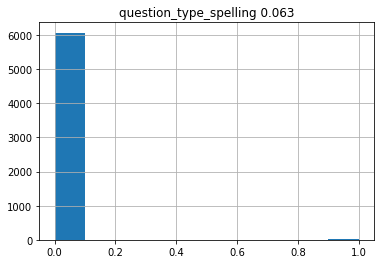

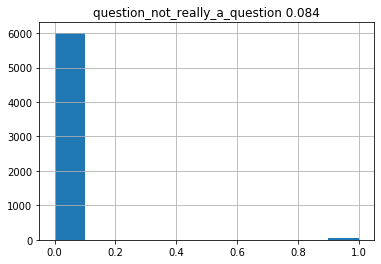

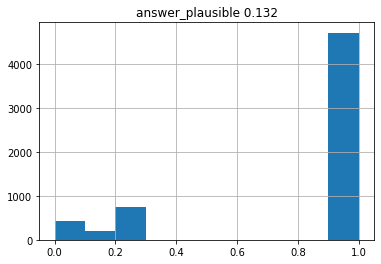

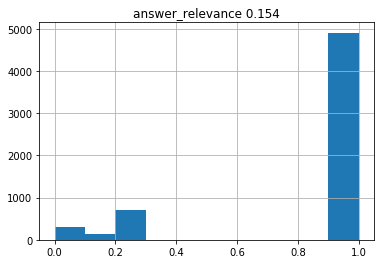

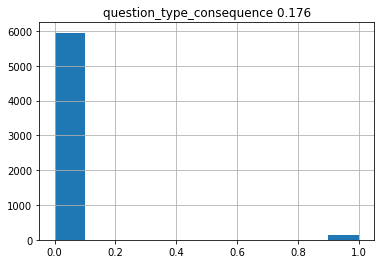

In [27]:
for col in worst_five_targets:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')

/home/robin/anaconda3/envs/GoogleQuest/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


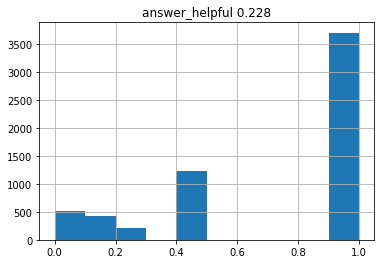

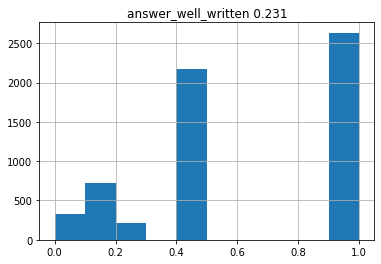

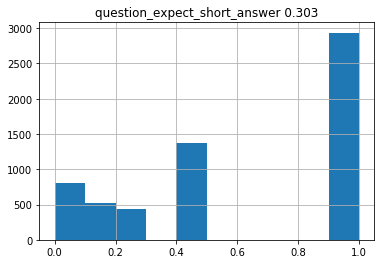

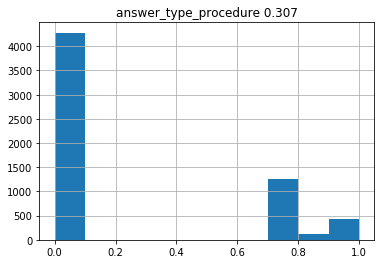

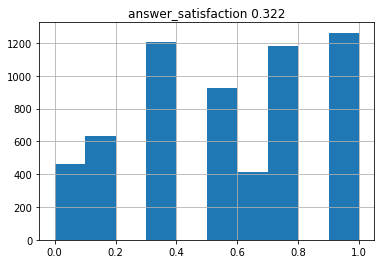

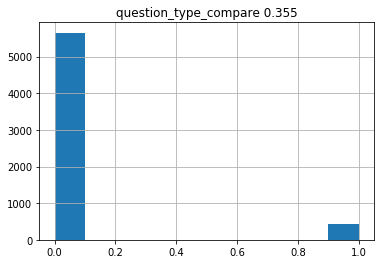

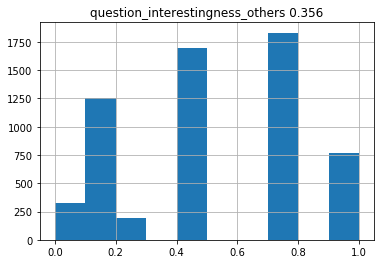

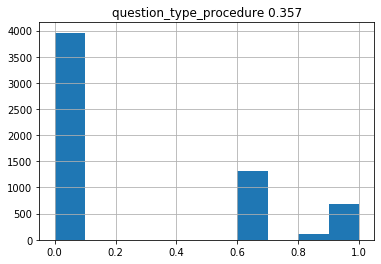

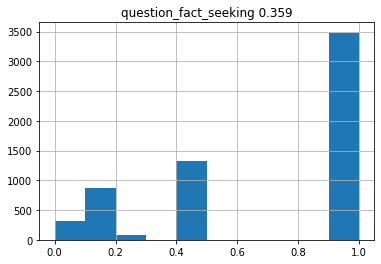

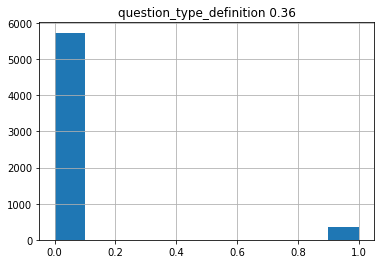

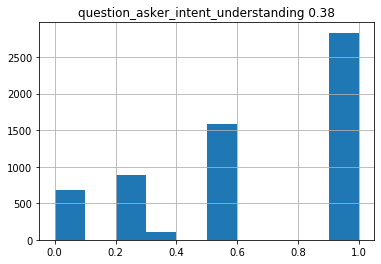

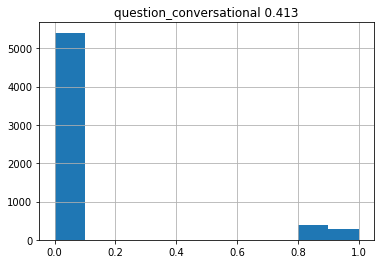

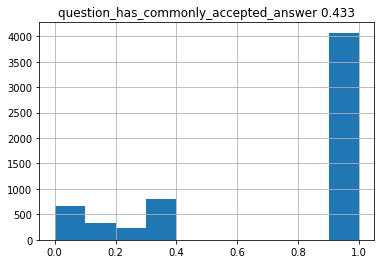

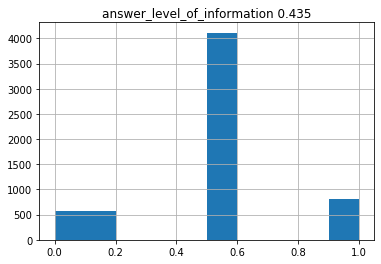

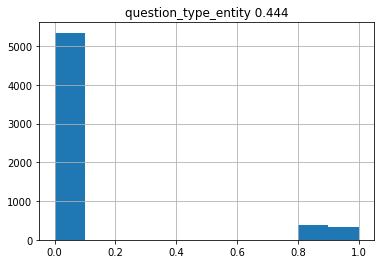

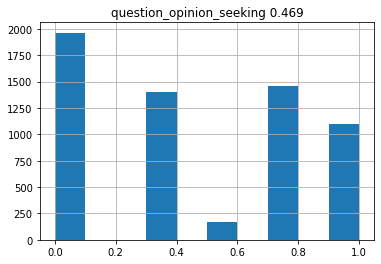

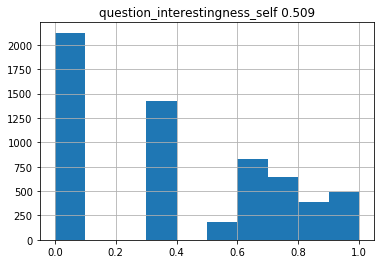

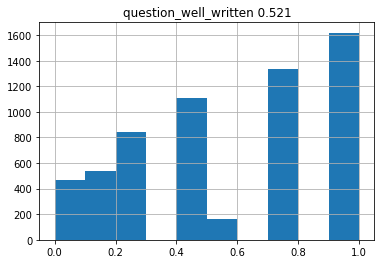

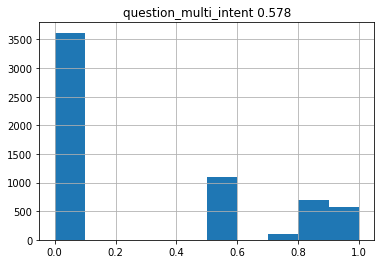

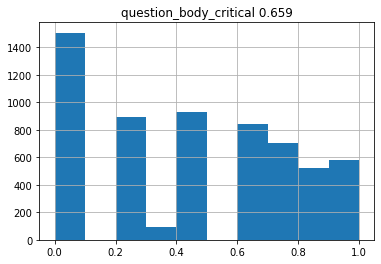

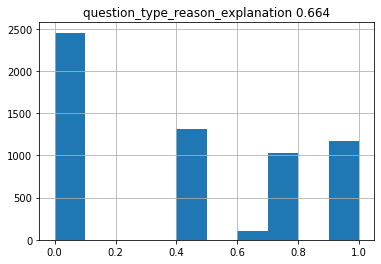

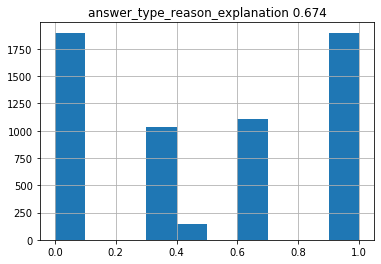

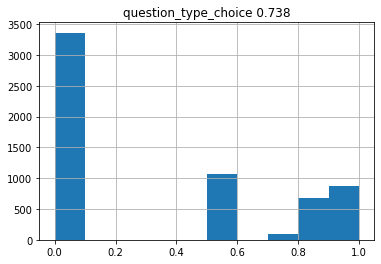

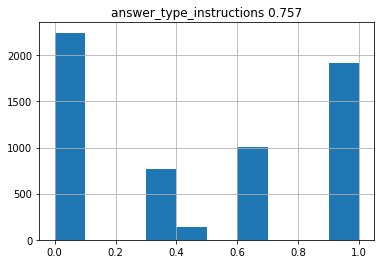

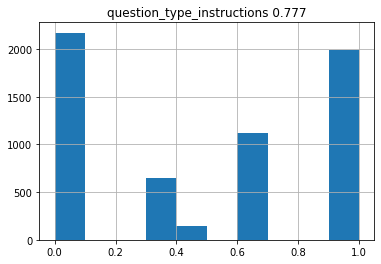

In [28]:
for col in [target for target in sorted_targets if target not in worst_five_targets]:
    plt.figure()
    train[col].hist()
    plt.title(f'{col} {np.round(rs[col],3)}')